# Signal correction pipeline optimization

Signal preprocessing pipeline is all set to go and installable from PyPi. Let's test it out and see how it runs. I'm mostly interested in how long it's going to take to process the whole dataset - submission notebook runtime limit is 9 hrs.

## Notebook set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


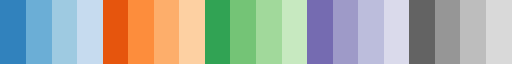

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import os
import psutil
import threading
import time

from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps as cm
from sklearn.linear_model import LinearRegression

# Local imports
import configuration as config

# Make sure the results directories exist
results_dir = f'{config.EXPERIMENT_RESULTS_DIRECTORY}/signal_correction_optimization'
Path(results_dir).mkdir(parents=True, exist_ok=True)

figures_dir = f'{config.FIGURES_DIRECTORY}/signal_correction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Signal correction pipeline

In [2]:
# Install and import the signal correction pipeline package
# !pip install ariel-data-preprocessing

from ariel_data_preprocessing.signal_correction import SignalCorrection

## 2. Run time: Downsampling

In [3]:
# Test runtime performance with different planet counts and downsampling options
planet_nums = [8,16,32]
downsampling = [True, False]

# Define results file path
file_name = f'signal_correction_runtimes-downsampling-{"-".join(map(str, planet_nums))}.csv'
runtime_results_file = f'{results_dir}/{file_name}'

# Run performance tests if results don't exist
if Path(runtime_results_file).is_file() is False:

    results = {
        'planet_nums': [],
        'runtimes': [],
        'downsampling': []
    }

    # Test both downsampling options
    for downsample in [True, False]:

        # Test different planet counts
        for planets in planet_nums:

            start_time = time.time()

            # Create and run signal correction pipeline
            signal_correction = SignalCorrection(
                input_data_path=config.RAW_DATA_DIRECTORY,
                output_data_path=config.SIGNAL_CORRECTED_DIRECTORY,
                n_planets=planets,
                downsample_fgs=downsample,
            )
            
            signal_correction.run()
            runtime = (time.time() - start_time) / 60

            # Store results
            results['downsampling'].append(downsample)
            results['planet_nums'].append(planets)
            results['runtimes'].append(runtime)

            print(f'Signal corrected {planets} planets, ' +
                  f'downsampling {downsample} - runtime {runtime:.1f} minutes')

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(runtime_results_file, index=False)

else:
    # Load existing results
    results_df = pd.read_csv(runtime_results_file)

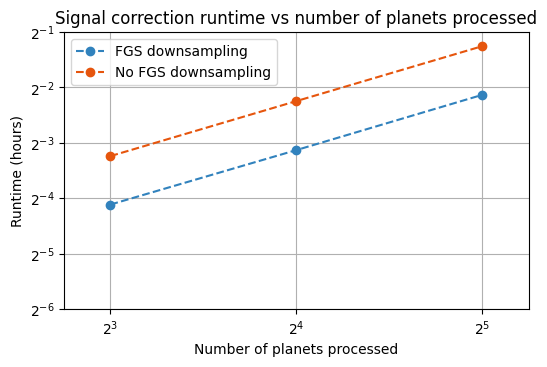

In [4]:
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))
plt.title('Signal correction runtime vs number of planets processed')

plt.plot(
    results_df[results_df['downsampling'] == True]['planet_nums'],
    results_df[results_df['downsampling'] == True]['runtimes'] / 60,
    color=config.BLUE,
    marker='o',
    linestyle='dashed',
    label='FGS downsampling'
)

plt.plot(
    results_df[results_df['downsampling'] == False]['planet_nums'],
    results_df[results_df['downsampling'] == False]['runtimes'] / 60,
    color=config.ORANGE,
    marker='o',
    linestyle='dashed',
    label='No FGS downsampling'
)

plt.xlabel('Number of planets processed')
plt.ylabel('Runtime (hours)')
plt.xlim(2**2.75, 2**5.25)
plt.ylim(2**-6, 2**-1)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.grid()
plt.legend(loc='upper left')

plt.savefig(
    f'{figures_dir}/02.2.1-runtime_vs_downsampling.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

In [5]:
# Analyze both downsampling conditions
for downsample in [True, False]:

    condition = "With" if downsample else "No"
    data = results_df[results_df['downsampling'] == downsample]
    
    # Fit linear regression
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    
    # Predict for 1100 planets
    prediction_min = model.predict([[1100]])[0]
    prediction_hrs = prediction_min / 60
    
    print(f"{condition} FGS1 downsampling:")
    print(f"  Slope: {model.coef_[0]:.3f} min/planet")
    print(f"  R²: {model.score(X, y):.3f}")
    print(f"  1100 planets: {prediction_min:.1f} min ({prediction_hrs:.1f} hrs)")
    print(f"  Within 9hr limit: {'pass' if prediction_hrs <= 9 else 'fail'}")
    print()

With FGS1 downsampling:
  Slope: 0.425 min/planet
  R²: 1.000
  1100 planets: 467.9 min (7.8 hrs)
  Within 9hr limit: pass

No FGS1 downsampling:
  Slope: 0.782 min/planet
  R²: 1.000
  1100 planets: 860.1 min (14.3 hrs)
  Within 9hr limit: fail



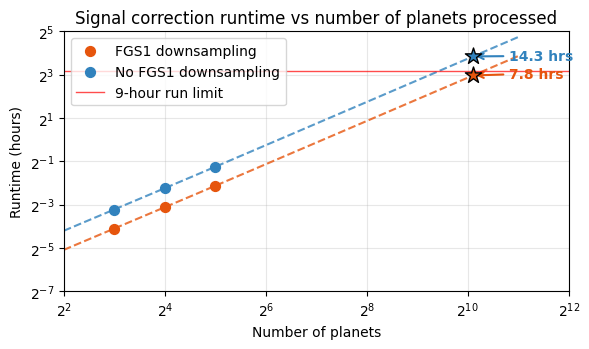

In [6]:
# Visualize linear regression predictions
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))

plot_colors = [config.ORANGE, config.BLUE]
labels = ['FGS1 downsampling', 'No FGS1 downsampling']
x_pred = np.linspace(2**2, 2**11, 100)

for i, downsample in enumerate([True, False]):

    data = results_df[results_df['downsampling'] == downsample]
    
    # Plot data points
    plt.scatter(
        data['planet_nums'],
        data['runtimes'] / 60, 
        color=plot_colors[i],
        s=50,
        label=labels[i],
        zorder=3
    )
    
    # Fit and plot regression line
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(x_pred.reshape(-1, 1)) / 60
    
    plt.plot(
        x_pred,
        y_pred,
        color=plot_colors[i],
        linestyle='--',
        alpha=0.8
    )
    
    # Show 1100 planet prediction
    pred_1100 = model.predict([[1100]])[0] / 60

    plt.scatter(
        [1100],
        [pred_1100],
        color=plot_colors[i],
        s=150,
        marker='*',
        edgecolors='black',
        zorder=4
    )

# Get model predictions for annotations
data_with_downsample = results_df[results_df['downsampling'] == True]
X_with_downsample = data_with_downsample['planet_nums'].values.reshape(-1, 1)
y_with_downsample = data_with_downsample['runtimes'].values
model_with_downsample = LinearRegression().fit(X_with_downsample, y_with_downsample)

data_no_downsample = results_df[results_df['downsampling'] == False]
X_no_downsample = data_no_downsample['planet_nums'].values.reshape(-1, 1)
y_no_downsample = data_no_downsample['runtimes'].values
model_no_downsample = LinearRegression().fit(X_no_downsample, y_no_downsample)

# Position annotations to avoid overlap
pred_with_downsample = model_with_downsample.predict([[1100]])[0] / 60
pred_no_downsample = model_no_downsample.predict([[1100]])[0] / 60

plt.annotate(
    f'{pred_with_downsample:.1f} hrs',
    xy=(1100, pred_with_downsample),
    xytext=(1800, pred_with_downsample - 0.5),
    color=config.ORANGE,
    fontweight='bold',
    arrowprops=dict(arrowstyle='->', color=config.ORANGE, lw=1.5)
)

plt.annotate(
    f'{pred_no_downsample:.1f} hrs',
    xy=(1100, pred_no_downsample),
    xytext=(1800, pred_no_downsample - 1.5),
    color=config.BLUE,
    fontweight='bold',
    arrowprops=dict(arrowstyle='->', color=config.BLUE, lw=1.5)
)

# Add 9-hour limit line
plt.axhline(y=9, color='red', linewidth=1, label='9-hour run limit', alpha=0.7)

plt.title('Signal correction runtime vs number of planets processed')
plt.xlabel('Number of planets')
plt.ylabel('Runtime (hours)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(2**2, 2**12)
plt.ylim(2**-7, 2**5)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.tight_layout()

plt.savefig(
    f'{figures_dir}/02.2.2-runtime_prediction_downsampling.jpg', 
    dpi=config.STD_FIG_DPI, 
    bbox_inches='tight'
)
plt.show()

## 3. Runtime: downsampling + parallelization

In [7]:
planet_nums = [8,16,32]
n_cpus = [1,2,3,4]

file_name = f'signal_correction_runtimes_n_cpus-{"-".join(map(str, planet_nums))}.csv'
runtime_results_file = f'{results_dir}/{file_name}'

if Path(runtime_results_file).is_file() is False:

    results = {
        'planet_nums': [],
        'runtimes': [],
        'n_cpus': [],
        'peak_memory_gb': [],
        'initial_memory_gb': []
    }

    for cpus in n_cpus:

        for planets in planet_nums:

            # Get initial system memory usage
            initial_memory = psutil.virtual_memory().used / (1024**3)  # Convert to GB
            peak_memory = [initial_memory]  # Use list to make it mutable
            monitoring = [True]  # Use list to make it mutable

            # Memory monitoring function that tracks all processes
            def monitor_memory(peak_memory_ref, monitoring_ref):
                main_process = psutil.Process(os.getpid())
                
                while monitoring_ref[0]:
                    try:
                        # Get memory usage of main process and all its children
                        total_memory = main_process.memory_info().rss
                        
                        # Add memory from all child processes
                        for child in main_process.children(recursive=True):
                            try:
                                total_memory += child.memory_info().rss

                            except (psutil.NoSuchProcess, psutil.AccessDenied):
                                # Child process may have terminated
                                continue
                        
                        total_memory_gb = total_memory / (1024**3)
                        peak_memory_ref[0] = max(peak_memory_ref[0], total_memory_gb)
                        time.sleep(0.1)  # Check every 100ms
                        
                    except Exception as e:
                        # Handle any other exceptions
                        break

            # Start memory monitoring in a separate thread
            monitor_thread = threading.Thread(
                target=monitor_memory, 
                args=(peak_memory, monitoring),
                daemon=True
            )

            monitor_thread.start()
            start_time = time.time()

            signal_correction = SignalCorrection(
                input_data_path=config.RAW_DATA_DIRECTORY,
                output_data_path=config.SIGNAL_CORRECTED_DIRECTORY,
                n_planets=planets,
                downsample_fgs=True,
                n_cpus=cpus,
            )
            
            signal_correction.run()

            # Stop monitoring
            monitoring[0] = False
            runtime_minutes = (time.time() - start_time) / 60

            results['n_cpus'].append(cpus)
            results['planet_nums'].append(planets)
            results['runtimes'].append(runtime_minutes)
            results['peak_memory_gb'].append(peak_memory[0])
            results['initial_memory_gb'].append(initial_memory)

            print(f'Signal corrected {planets} planets, {cpus} cpus - ' +
                  f'{runtime_minutes:.1f} min, {peak_memory[0]:.1f} GB peak')

    results_df = pd.DataFrame(results)
    results_df.to_csv(runtime_results_file, index=False)

else:
    results_df = pd.read_csv(runtime_results_file)

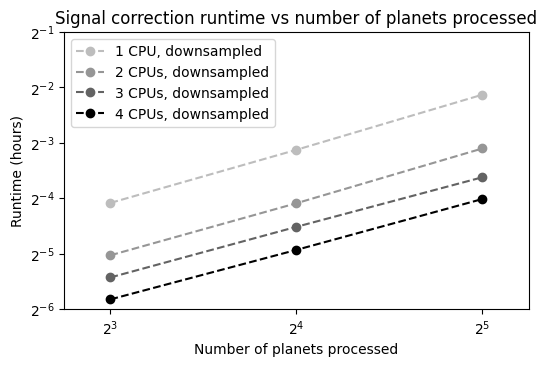

In [8]:
plot_colors = [config.COLORS[18], config.COLORS[17], config.COLORS[16], 'black']

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))
plt.title('Signal correction runtime vs number of planets processed')

for i, cpus in enumerate(n_cpus):

    data = results_df[results_df['n_cpus'] == cpus]

    plt.plot(
        data['planet_nums'],
        data['runtimes'] / 60,
        color=plot_colors[i],
        marker='o',
        linestyle='dashed',
        label=f'{cpus} CPU{"s" if cpus > 1 else ""}, downsampled'
    )

plt.xlabel('Number of planets processed')
plt.ylabel('Runtime (hours)')
plt.xlim(2**2.75, 2**5.25)
plt.ylim(2**-6, 2**-1)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend(loc='upper left')
plt.savefig(
    f'{figures_dir}/02.2.3-runtime_vs_cpu_count.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

In [9]:
# Linear regression to predict runtime for 1100 planets with different CPU counts
print("Runtime predictions for 1100 planets with parallelization:")
print("=" * 60)

# Analyze each CPU configuration
for cpus in n_cpus:
    data = results_df[results_df['n_cpus'] == cpus]
    
    # Fit linear regression
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    
    # Predict for 1100 planets
    prediction_min = model.predict([[1100]])[0]
    prediction_hrs = prediction_min / 60
    
    print(f"{cpus} CPU{'s' if cpus > 1 else ''}:")
    print(f"  Slope: {model.coef_[0]:.3f} min/planet")
    print(f"  R²: {model.score(X, y):.3f}")
    print(f"  1100 planets: {prediction_min:.1f} min ({prediction_hrs:.1f} hrs)")
    print(f"  Within 9hr limit: {'pass' if prediction_hrs <= 9 else '✗ fail'}")
    print()

# Calculate speedup factors
single_cpu_data = results_df[results_df['n_cpus'] == 1]
X_single = single_cpu_data['planet_nums'].values.reshape(-1, 1)
y_single = single_cpu_data['runtimes'].values
model_single = LinearRegression().fit(X_single, y_single)
baseline_time = model_single.predict([[1100]])[0] / 60

print("Speedup analysis:")
print("=" * 30)

for cpus in n_cpus:

    data = results_df[results_df['n_cpus'] == cpus]
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    predicted_time = model.predict([[1100]])[0] / 60
    speedup = baseline_time / predicted_time
    
    print(f"{cpus} CPU{'s' if cpus > 1 else ''}: {speedup:.2f}x speedup")

Runtime predictions for 1100 planets with parallelization:
1 CPU:
  Slope: 0.423 min/planet
  R²: 1.000
  1100 planets: 465.9 min (7.8 hrs)
  Within 9hr limit: pass

2 CPUs:
  Slope: 0.215 min/planet
  R²: 1.000
  1100 planets: 236.5 min (3.9 hrs)
  Within 9hr limit: pass

3 CPUs:
  Slope: 0.144 min/planet
  R²: 1.000
  1100 planets: 159.2 min (2.7 hrs)
  Within 9hr limit: pass

4 CPUs:
  Slope: 0.110 min/planet
  R²: 1.000
  1100 planets: 121.7 min (2.0 hrs)
  Within 9hr limit: pass

Speedup analysis:
1 CPU: 1.00x speedup
2 CPUs: 1.97x speedup
3 CPUs: 2.93x speedup
4 CPUs: 3.83x speedup


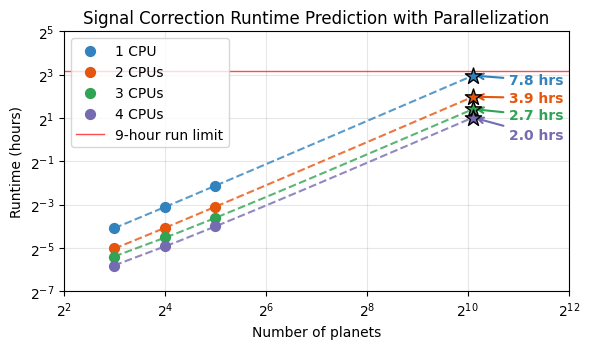

In [10]:
# Visualize linear regression predictions for parallelization
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))

plot_colors = [config.BLUE, config.ORANGE, config.GREEN, config.PURPLE]
x_pred = np.linspace(8, 1100, 100)

for i, cpus in enumerate(n_cpus):
    data = results_df[results_df['n_cpus'] == cpus]
    
    # Plot data points
    plt.scatter(
        data['planet_nums'],
        data['runtimes'] / 60, 
        color=plot_colors[i],
        s=50,
        label=f'{cpus} CPU{"s" if cpus > 1 else ""}',
        zorder=3
    )
    
    # Fit and plot regression line
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(x_pred.reshape(-1, 1)) / 60
    
    plt.plot(
        x_pred,
        y_pred,
        color=plot_colors[i],
        linestyle='--',
        alpha=0.8
    )
    
    # Show 1100 planet prediction
    pred_1100 = model.predict([[1100]])[0] / 60
    
    plt.scatter(
        [1100],
        [pred_1100],
        color=plot_colors[i],
        s=150,
        marker='*', 
        edgecolors='black',
        zorder=4
    )
    
    # Position annotations to avoid overlap
    if cpus == 1:
        label_pos = (1800, pred_1100 - 1.9)
    elif cpus == 2:
        label_pos = (1800, pred_1100 - 0.6)
    elif cpus == 3:
        label_pos = (1800, pred_1100 - 0.75)
    else:  # cpus == 4
        label_pos = (1800, pred_1100 - 1.0)
    
    plt.annotate(
        f'{pred_1100:.1f} hrs',
        xy=(1100, pred_1100), 
        xytext=label_pos,
        color=plot_colors[i],
        fontweight='bold',
        arrowprops=dict(arrowstyle='->', color=plot_colors[i], lw=1.5)
    )

# Add 9-hour limit line
plt.axhline(y=9, color='red', linewidth=1, label='9-hour run limit', alpha=0.7)

plt.title('Signal Correction Runtime Prediction with Parallelization')
plt.xlabel('Number of planets')
plt.ylabel('Runtime (hours)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(2**2, 2**12)
plt.ylim(2**-7, 2**5)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.tight_layout()

plt.savefig(
    f'{figures_dir}/02.2.4-predicted_runtime_vs_planets_cpu_count.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

## 4. Runtime as a function of CPU count

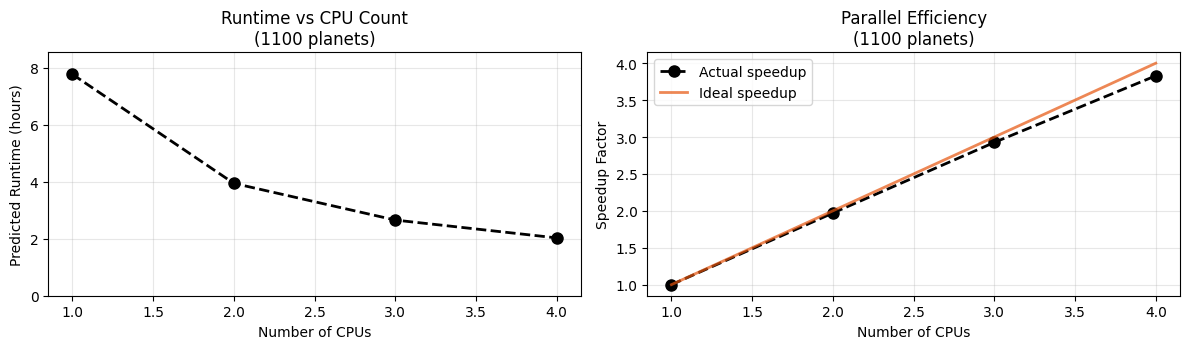

Summary for 1100 planets:
1 CPU: 7.8h (1.00x, 100% eff.)
2 CPUs: 3.9h (1.97x, 99% eff.)
3 CPUs: 2.7h (2.93x, 98% eff.)
4 CPUs: 2.0h (3.83x, 96% eff.)


In [11]:
# Calculate predicted runtimes for 1100 planets for each CPU count
cpu_counts = []
predicted_runtimes_hrs = []
speedups = []

# Get baseline (1 CPU) for speedup calculation
single_cpu_data = results_df[results_df['n_cpus'] == 1]
X_single = single_cpu_data['planet_nums'].values.reshape(-1, 1)
y_single = single_cpu_data['runtimes'].values
model_single = LinearRegression().fit(X_single, y_single)
baseline_time_hrs = model_single.predict([[1100]])[0] / 60

for cpus in n_cpus:

    data = results_df[results_df['n_cpus'] == cpus]
    
    # Fit linear regression
    X = data['planet_nums'].values.reshape(-1, 1)
    y = data['runtimes'].values
    model = LinearRegression().fit(X, y)
    
    # Predict for 1100 planets
    prediction_hrs = model.predict([[1100]])[0] / 60
    speedup = baseline_time_hrs / prediction_hrs
    
    cpu_counts.append(cpus)
    predicted_runtimes_hrs.append(prediction_hrs)
    speedups.append(speedup)

# Create the plot
fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH * 0.6)
)

# Plot 1: Runtime vs CPU count
ax1.plot(
    cpu_counts,
    predicted_runtimes_hrs,
    color='black',
    linestyle='--', marker='o',
    linewidth=2,
    markersize=8
)

ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Predicted Runtime (hours)')
ax1.set_title('Runtime vs CPU Count\n(1100 planets)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(predicted_runtimes_hrs) * 1.1)

# Plot 2: Speedup vs CPU count
ax2.plot(
    cpu_counts,
    speedups,
    color='black',
    linestyle='--',
    marker='o',
    linewidth=2, 
    markersize=8,
    label='Actual speedup'
)

ax2.plot(
    cpu_counts,
    cpu_counts,
    color=config.ORANGE,
    linestyle='-',
    linewidth=2,
    alpha=0.7,
    label='Ideal speedup'
)

ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Parallel Efficiency\n(1100 planets)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(
    f'{figures_dir}/02.2.5-predicted_runtime-efficiency_vs_cpu_count.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

# Print summary
print("Summary for 1100 planets:")
print("=" * 40)

for cpus, runtime, speedup in zip(cpu_counts, predicted_runtimes_hrs, speedups):
    efficiency = speedup / cpus * 100
    print(f"{cpus} CPU{'s' if cpus > 1 else ''}: {runtime:.1f}h ({speedup:.2f}x, {efficiency:.0f}% eff.)")

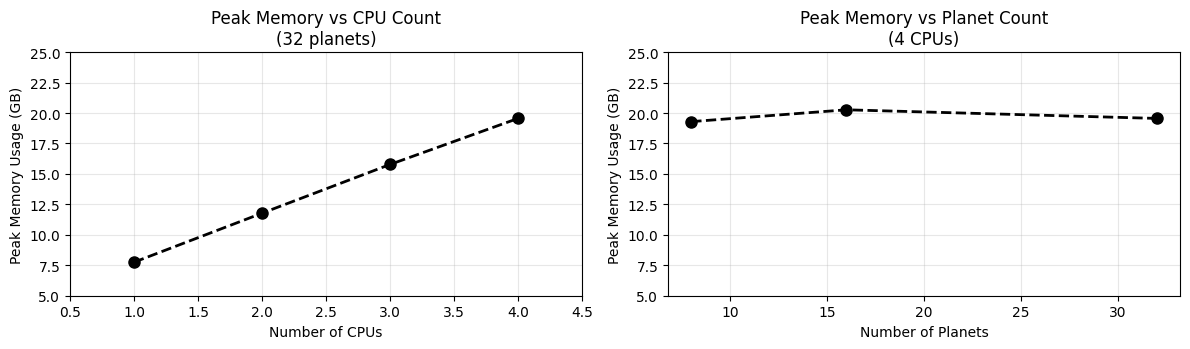

Memory scaling analysis:
For 32 planets:
  1 CPU: 7.8 GB
  2 CPUs: 11.8 GB
  3 CPUs: 15.8 GB
  4 CPUs: 19.6 GB

For 4 CPUs:
  8 planets: 19.3 GB
  16 planets: 20.3 GB
  32 planets: 19.6 GB


In [12]:
# Plot peak memory usage analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH * 0.6))

# Plot 1: Peak memory vs CPU count for 32 planets
data_32_planets = results_df[results_df['planet_nums'] == 32]
cpu_counts_32 = data_32_planets['n_cpus'].values
peak_memory_32 = data_32_planets['peak_memory_gb'].values

ax1.plot(
    cpu_counts_32,
    peak_memory_32,
    color='black',
    linestyle='--',
    marker='o',
    linewidth=2,
    markersize=8
)

ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Peak Memory Usage (GB)')
ax1.set_title('Peak Memory vs CPU Count\n(32 planets)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(5, 25)
ax1.set_xlim(0.5, max(cpu_counts_32) + 0.5)

# Plot 2: Peak memory vs number of planets for 4 CPUs
data_4_cpus = results_df[results_df['n_cpus'] == 4]
planet_counts = data_4_cpus['planet_nums'].values
peak_memory_4cpu = data_4_cpus['peak_memory_gb'].values

ax2.plot(
    planet_counts,
    peak_memory_4cpu,
    color='black',
    linestyle='--',
    marker='o',
    linewidth=2,
    markersize=8
)
ax2.set_xlabel('Number of Planets')
ax2.set_ylabel('Peak Memory Usage (GB)')
ax2.set_title('Peak Memory vs Planet Count\n(4 CPUs)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(5, 25)

plt.tight_layout()
plt.savefig(
    f'{figures_dir}/02.2.6-memory_vs_cpu_count.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)
plt.show()

# Print memory scaling summary
print("Memory scaling analysis:")
print("=" * 35)
print("For 32 planets:")

for cpus, memory in zip(cpu_counts_32, peak_memory_32):
    print(f"  {cpus} CPU{'s' if cpus > 1 else ''}: {memory:.1f} GB")

print("\nFor 4 CPUs:")

for planets, memory in zip(planet_counts, peak_memory_4cpu):
    print(f"  {planets} planets: {memory:.1f} GB")